# Project 7: Introduction to Machine Learning

### Author: Data-Git-Hub

### GitHub Project Repository Link: https://github.com/Data-Git-Hub/datafun-07-ml

---

### Import Necessary Python Libraries and Tools for Project 7

In [24]:
import numpy as np
import pandas as pd
import pyarrow as pa
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

### Check Library Versions

In [25]:
# Check versions
print("NumPy Version:", np.__version__)
print("Pandas Version:", pd.__version__)
print("PyArrow Version:", pa.__version__)
print("Matplotlib Version:", plt.matplotlib.__version__)
print("Seaborn Version:", sns.__version__)
print("SciPy Version:", scipy.__version__)

NumPy Version: 2.2.3
Pandas Version: 2.2.3
PyArrow Version: 19.0.0
Matplotlib Version: 3.10.0
Seaborn Version: 0.13.2
SciPy Version: 1.15.1


## Chart a Straight Line (Section 1)

### Define Temperature Data

In [26]:
# Define temperature data
celsius = list(range(-20, 41, 5))  # Celsius values from -20 to 40 in steps of 5
fahrenheit = [(c * 9/5) + 32 for c in celsius]  # Convert to Fahrenheit

### Create a DataFrame

In [27]:
# Create a DataFrame
df = pd.DataFrame({'Celsius': celsius, 'Fahrenheit': fahrenheit})

### Plot and Label the Data

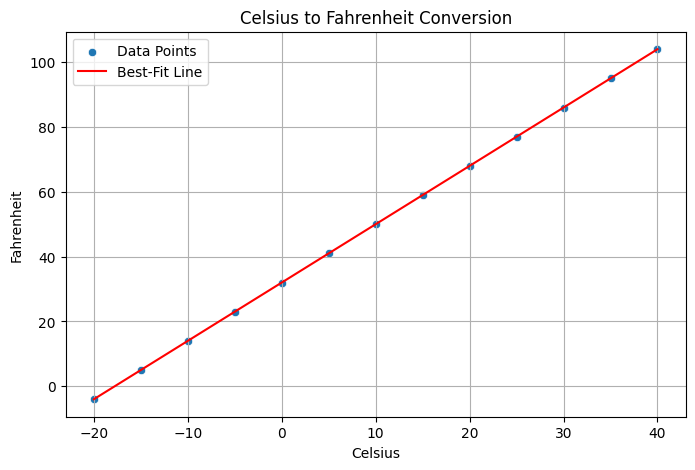

In [28]:
# Plot the data
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df['Celsius'], y=df['Fahrenheit'], label='Data Points')
sns.lineplot(x=df['Celsius'], y=df['Fahrenheit'], color='red', label='Best-Fit Line')

# Labels and title
plt.xlabel('Celsius')
plt.ylabel('Fahrenheit')
plt.title('Celsius to Fahrenheit Conversion')
plt.legend()
plt.grid()

# Show the plot
plt.show()

### Understanding the Equation of a Line

##### The equation of a straight line is given by y = mx + b, where m is the slope of the line, and b is the y-intercept (the point where the line crosses the y-axis). In the case of converting Celsius to Fahrenheit, the slope represents the rate at which Fahrenheit changes as Celsius increases. The slope, m, is calculated as the change in Fahrenheit divided by the change in Celsius. Since Fahrenheit is derived using the formula F = (9/5) * C + 32, the slope is 9/5 or 1.8. The y-intercept, b, is the value of Fahrenheit when Celsius is zero, which is 32. This means that the equation for converting Celsius to Fahrenheit is F = 1.8C + 32. This linear relationship allows us to predict Fahrenheit values for any given Celsius input.